In [2]:
# IMPORT LIBRARIES

from scipy import stats
import galpy.potential
from galpy.orbit import Orbit
from astropy import units as u
from galpy.potential import LogarithmicHaloPotential
import numpy as np
from galpy.potential import MWPotential2014,PowerSphericalPotential
import matplotlib.pyplot as plt
import astropy.units as u
from orbit_functions import *
import pickle
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from scipy.ndimage import gaussian_filter
from galpy.potential import plotRotcurve
from functools import partial
from scipy.fft import *
from scipy import interpolate, optimize
from astropy.io import fits
from astropy.table import Table


# DATA LOADER

class Loader():
    o_cache = None
    o_cache_name = None
    oo = None
    new = False

    def load_model(self, model, time, xmin=1000, xmax=3000, phi_range=0.2, maxvr=20):
        if model == 'MW_Sgr':
            Rmax=16.
            snap=str(int(np.round(time*100))) if time>=1 else '0'+str(int(time*100))
            df = Table.read('MW_Sgr/disk'+snap+'.fits', format='fits').to_pandas()
            df['X'],df['Y'],df['Z'],df['VX'],df['VY'],df['VZ']=cyl2cart(df['R'],df['phi'],df['Z'],df['VR'],df['Vphi'],df['VZ'])
            ind=df['R']<Rmax
            df=df[ind]    
            x,y,z,VR,Vphi,VZ,R,phi=df['X'],df['Y'],df['Z'],df['VR'],df['Vphi'],df['VZ'],df['R'],df['phi']
            Vphi=Vphi*-1.
            Lz=R*Vphi
        else:
            if self.o_cache_name == model:
                o = self.o_cache
            else:
                file='o_galpy/o_'+model+'.pkl'
                with open(file, 'rb') as f:#for orbits after perturbation
                    o = pickle.load(f)
                self.o_cache = o
                self.o_cache_name = model

            t=time*u.Gyr
            x=o.x(t)
            y=-o.y(t)#in galpy, orbits turn counterclockwise. changing sign of y we turn it into clockwise
            VR=o.vr(t)
            Vphi=o.vphi(t)*o.r(t)
            R=o.r(t)
            Lz=R*Vphi
            phi=o.phi(t)

        indphi=(np.abs(phi)>np.pi-phi_range)&(np.abs(phi)<np.pi+phi_range)
        x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
        indphi=(np.abs(VR)<maxvr)&(Lz>xmin)&(Lz<xmax)
        x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
        DATA = False
        
        return x,y,VR,Vphi,R,Lz,phi

    def load_data(self, xmin=1500, xmax=3500, phi_range=0.4, new=False):
        if self.oo == None or self.new != new:
            self.new = new
            path = 'o_galpy/SoS_SH_Gaia_test_GAL6D.fits'
            if new:
                path = 'o_galpy/DR3_SH_ruwe14_fidelity05_pioe5_GAL6D.fits'
            self.oo = Table.read(path, format='fits')
        oo = self.oo

        VR,Vphi,VZ,x,y,Z,R,phi=np.array((oo['VR'],oo['Vphi'],oo['VZ'],oo['X'],oo['Y'],oo['Z'],oo['R'],oo['phi']))
        Lz=-oo['Vphi']*oo['R']
        phi=-np.deg2rad(phi)
        Vphi=-Vphi
        
        indphi = abs(phi) < phi_range
        x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
        indphi=(Lz>xmin)&(Lz<xmax)
        x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
        
        DATA = True
        return x,y,VR,Vphi,R,Lz,phi

# Initialize data loader
l = Loader()


# AUXILIARY FUNCTIONS

# Group the data into bins in x and get the average y for each bin
def smooth_bins(x, y, xmin, xmax, binsize):
    binsLZ=np.arange(xmin,xmax,binsize)
    m,xedge,binnumber=stats.binned_statistic(x, y, statistic='mean', bins=[binsLZ]) 
    nx = np.arange(xmin-binsize/2, xmax, binsize)
    xpol = nx + binsize/2
    means = []
    for k in nx:
        rel = y[(k<x) & (x<k+binsize)]
        if len(rel) == 0:
            means.append(means[-1])
        else:
            means.append(np.mean(rel))
    ypol = np.array(means)
    return xpol, ypol

# Get an equispaced curve from a number of points
def curve_from_bins(nx, ny, N):
    f = interpolate.interp1d(nx, ny, kind='linear')
    xpol = np.linspace(nx[0], nx[-1], N)
    ypol = f(xpol)
    xpol = xpol[~np.isnan(ypol)]
    ypol = ypol[~np.isnan(ypol)]
    return xpol, ypol

# Perform Fourier transform on a curve
def fourier_from_curve(xpol, ypol):
    N = len(xpol)
    ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
    yf = fft(ypol)
    xf = fftfreq(N)
    yf = yf[xf>0]
    xf = xf[xf>0]
    xfr = ((xpol[-1]-xpol[0]) / abs(xf * N))
    return xfr, yf

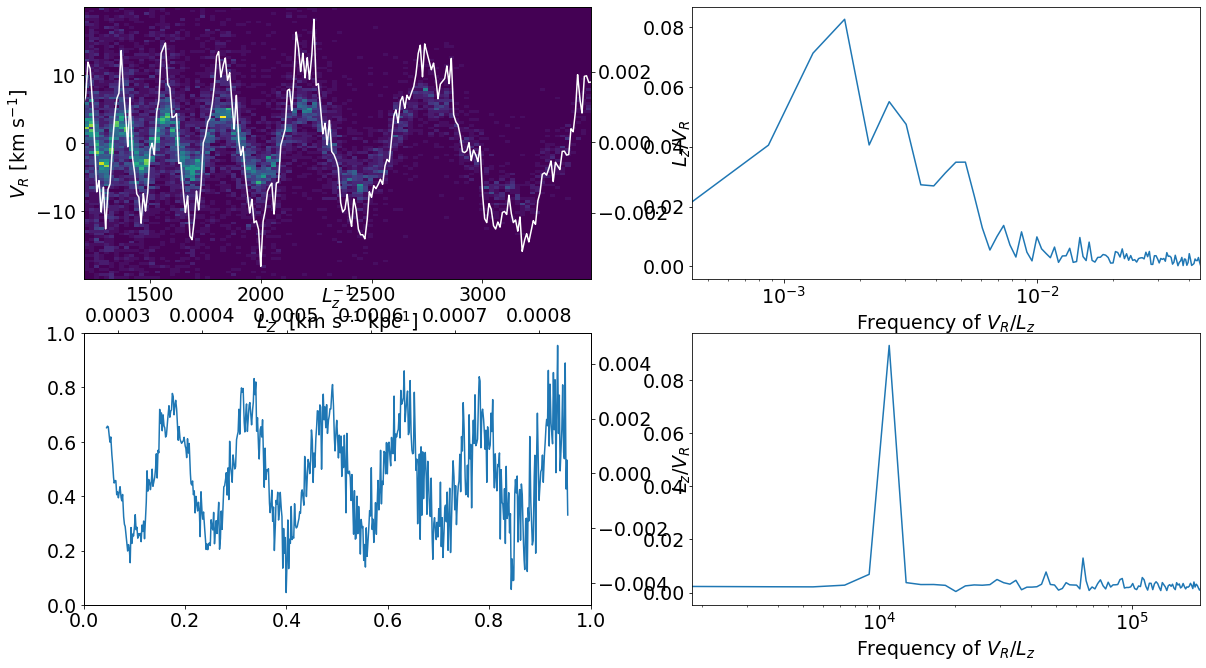

In [32]:
# Plot untransformed and transformed (with Lz**nexp) simulation data, and their Fourier transforms

# Load model
TIME = 2.0
XMIN=1200
XMAX=3500
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_model('Dhot_log', TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2)
DATA = False

fig, ax = plt.subplots(2,2,figsize=(20,11))

# Background histogram
nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
N = 100000
ax[0][0].hist2d(Lz, VR, bins=100);
ax[0][0].set_aspect('auto')
ax[0][0].set_xlabel(r'$L_Z$  [km s$^{-1}$ kpc$^{1}$]')
ax[0][0].set_ylabel(r'$V_R$ [km s$^{-1}$] ')

# Fourier analysis, untransformed
nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, BINSIZE)
N = 100000
xpol, ypol = curve_from_bins(nx, ny, N)
xfr, yf = fourier_from_curve(xpol, ypol)

# Plot Fourier
ax_right = ax[0][0].twinx()
ax_right.plot(xpol, ypol, c='white')
ax_right.set_ylabel('$L_z/V_R$')
ax[0][1].plot(1/xfr, np.abs(yf)/np.sum(np.abs(yf)))
ax[0][1].set_xlim(1/max(xfr), 1/xfr[100])
ax[0][1].set_xscale('log')
ax[0][1].set_aspect('auto')
ax[0][1].set_xlabel('Frequency of $V_R/L_z$')

# Fourier analysis, transformed
nexp = -1
nx, ny = smooth_bins(Lz**nexp, VR/Lz, np.min(Lz**nexp), np.max(Lz**nexp), 1e-6)
N = 100000
xpol, ypol = curve_from_bins(nx, ny, N)
xfr, yf = fourier_from_curve(xpol, ypol)

# Plot Fourier
ax_right = ax[1][0].twiny()
ax_right.set_xlabel('$L_z^{-1}$')
ax_right = ax_right.twinx()
ax_right.plot(xpol, ypol)
ax_right.set_ylabel('$L_z/V_R$')
ax[1][1].plot(1/xfr, np.abs(yf)/np.sum(np.abs(yf)))
ax[1][1].set_xlim(1/max(xfr), 1/xfr[100])
ax[1][1].set_xscale('log')
ax[1][1].set_aspect('auto')
ax[1][1].set_xlabel('Frequency of $V_R/L_z$')

namef='plots/fourier_procedure'+'.png'
plt.savefig(namef, bbox_inches='tight')

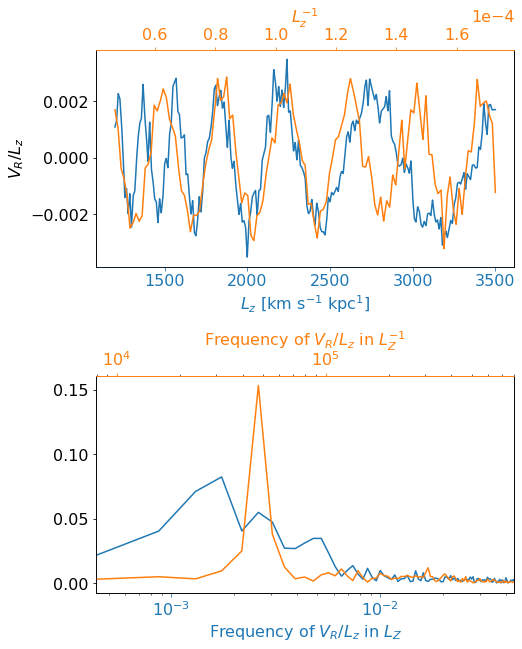

In [38]:
# Plot untransformed and transformed (with Lz**nexp) simulation data, and their Fourier transforms

plt.rcParams['font.size'] = 16

# Load model
TIME = 2.0
XMIN=1200
XMAX=3500
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_model('Dhot_log', TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2)
DATA = False

fig, ax = plt.subplots(2,1,figsize=(7.5,10))
plt.subplots_adjust(hspace=0.5)

# Fourier analysis, untransformed
nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, BINSIZE)
N = 100000
xpol, ypol = curve_from_bins(nx, ny, N)
xfr, yf = fourier_from_curve(xpol, ypol)

# Plot
ax[0].plot(xpol, ypol, c='C0')
ax[0].set_aspect('auto')
ax[0].spines['bottom'].set_color('C0')
ax[0].tick_params(axis='x', colors='C0')
ax[0].set_xlabel(r'$L_z$ [km s$^{-1}$ kpc$^{1}$]')
ax[0].spines['top'].set_color('C1')
ax[0].xaxis.label.set_color('C0')
ax[0].set_ylabel(r'$V_R/L_z$')
ax[1].plot(1/xfr, np.abs(yf)/np.sum(np.abs(yf)), color='C0')
ax[1].set_xlim(1/max(xfr), 1/xfr[100])
ax[1].set_xscale('log')
ax[1].set_aspect('auto')
ax[1].set_xlabel('Frequency of $V_R/L_z$ in $L_Z$')
ax[1].spines['top'].set_color('C1')
ax[1].tick_params(axis='x', colors='C0')
ax[1].xaxis.label.set_color('C0')

# Fourier analysis, transformed
n = -0.1
nx, ny = smooth_bins(Lz**((n-1)/(n+1)), VR/Lz, np.min(Lz**((n-1)/(n+1))), np.max(Lz**((n-1)/(n+1))), 1e-6)
N = 100000
xpol, ypol = curve_from_bins(nx, ny, N)
xfr, yf = fourier_from_curve(xpol, ypol)

# Plot
axb = ax[0].twiny()
axb.plot(xpol, ypol, c='C1')
axb.spines['top'].set_color('C1')
axb.tick_params(axis='x', colors='C1')
axb.set_xlabel(r'$L_z^{-1}$')
axb.xaxis.label.set_color('C1')
plt.ticklabel_format(style='sci', axis='x', scilimits=(1e-3,1e4))
axb = ax[1].twiny()
axb.plot(1/xfr, np.abs(yf)/np.sum(np.abs(yf)), color='C1')
axb.set_xlim(1/max(xfr), 1/xfr[100])
axb.set_xscale('log')
axb.set_aspect('auto')
axb.set_xlabel('Frequency of $V_R/L_z$ in $L_Z^{-1}$')
axb.spines['top'].set_color('C1')
axb.tick_params(axis='x', colors='C1')
axb.xaxis.label.set_color('C1')


namef='plots/fourier_procedure'+'.png'
plt.savefig(namef, bbox_inches='tight')

Dhot_log
Dhotn10_pn10
Dhotn_10_pn_10
Dhot_log_2perturb


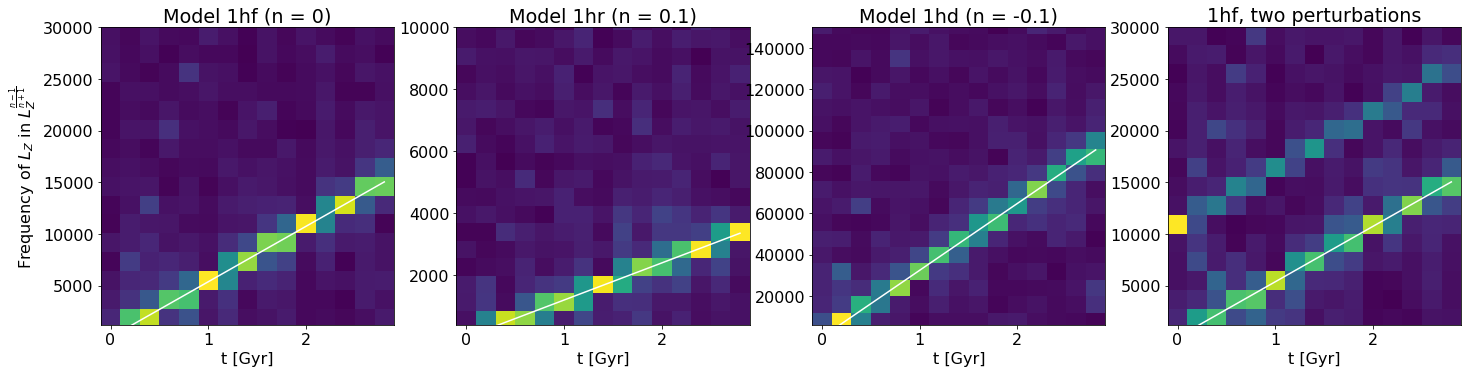

In [21]:
# Plot the evolution of the Fourier transform of the simulations over time,
# and the frequency predicted by the theoretical formula

plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(1,4,figsize=(20,5))
fig.tight_layout()

eps = 0.00001
times = np.arange(eps, 3.0+eps, 0.2)
vtimes = list(times)

ns = [0,0.1,-0.1,0]  # n for transformations
ylims=[30000,10000,150000,30000]
model_labels = ['Model 1hf (n = 0)', 'Model 1hr (n = 0.1)', 'Model 1hd (n = -0.1)', '1hf, two perturbations']

for model_i, model in enumerate(['Dhot_log', 'Dhotn10_pn10', 'Dhotn_10_pn_10', 'Dhot_log_2perturb']):
    print(model)
    
    # Fourier transform for all times
    fourier = []
    for time in times:
        XMIN=1200
        XMAX=3500
        BINSIZE = 10
        x,y,VR,Vphi,R,Lz,phi=l.load_model(model, time, xmin=XMIN, xmax=XMAX, phi_range=0.2)
        DATA = False

        n = ns[model_i]
        nx, ny = smooth_bins(Lz**((n-1)/(n+1)), VR/Lz, np.min(Lz**((n-1)/(n+1))), np.max(Lz**((n-1)/(n+1))), 1e-6)
        N = 100000
        xpol, ypol = curve_from_bins(nx, ny, N)
        xfr, yf = fourier_from_curve(xpol, ypol)
        fourier.append(yf)

    fourier = np.abs(np.array(fourier))
    xfr = xfr[:100]
    fourier = fourier[:,:100]
    Z = fourier.T/np.sum(fourier, axis=1)
    
    ax[model_i].pcolormesh(times, 1/xfr, Z, cmap='viridis')
    ax[model_i].set_xlabel('t [Gyr]')
    ax[model_i].set_ylim(ylims[model_i]/25,ylims[model_i])
    ax[model_i].set_title(model_labels[model_i])
    ax[0].set_ylabel(r'Frequency of $L_Z$ in $L_Z^{\frac{n-1}{n+1}}$')
    
    # Theoretical frequency curve
    def freqcurve(t, n):
        Vc = 240
        R0 = 8
        ct = (Vc / R0**n) ** (2/(1+n)) * (1-0.5*np.sqrt(2*n+2)) / np.pi
        return ct * t
    
    ax[model_i].plot(times, freqcurve(times, n=ns[model_i]), c='w')


namef='plots/fourier_time'+'_simplemodels'+'.png'
plt.savefig(namef, bbox_inches='tight')


In [3]:
# The same as the previous plot, but with the MW_Sgr simulation.
# Part 1: Process the data (takes a long time)

eps = 0.00001
times = np.arange(0.1, 7.0, 0.1)
vtimes = list(times)

binsizes = [10, 1e-6]
n = (-0.1-1)/(-0.1+1)
for tfi, tf in enumerate([lambda x: x, lambda x: x**n]):
    fourier = []
    freqs = []
    freqs2 = []
    for time in times:
        print(f'{time:.2}')

        XMIN=1000
        XMAX=3500
        BINSIZE = 50
        x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', time, xmin=XMIN, xmax=XMAX, phi_range=0.2, maxvr=100)
        DATA = False

        nx, ny = smooth_bins(tf(Lz), VR/Lz, np.min(tf(Lz)), np.max(tf(Lz)), binsizes[tfi])
        N = 100000
        xpol, ypol = curve_from_bins(nx, ny, N)
        xfr, yf = fourier_from_curve(xpol, ypol)
        fourier.append(yf)

    np.save(f'fourier_time_mwsgr_10_35_{tfi}.npy', fourier)
    np.save(f'xfr_time_mwsgr_10_35_{tfi}.npy', xfr)


0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9


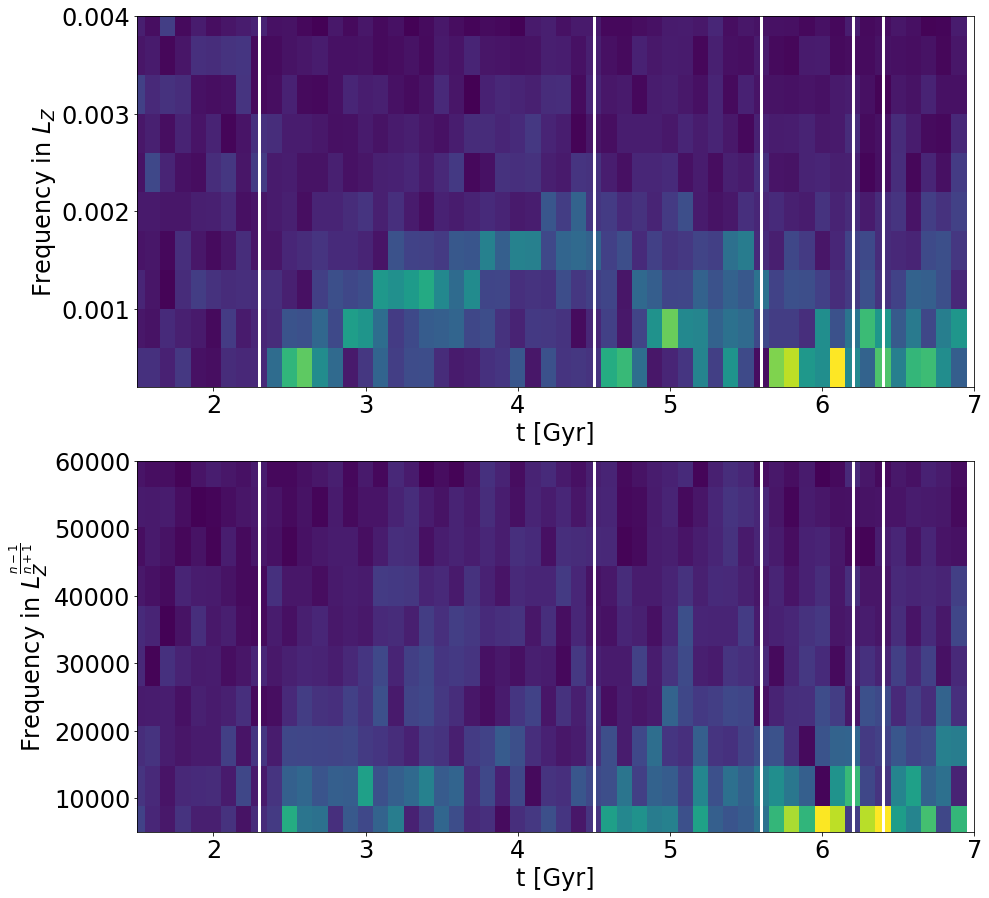

In [5]:
# Part 2: Make the plot

plt.rcParams['font.size'] = 24

fig, ax = plt.subplots(2,1,figsize=(15,15))
times = np.arange(0.1, 7.0, 0.1)
ylims = [[0.00020,0.004], [5000,60000]]
desc = ["L_Z", r"L_Z^{\frac{n-1}{n+1}}"]
for tfi in range(2):
    fourier = np.load(f'fourier_time_mwsgr_10_35_{tfi}.npy')
    xfr = np.load(f'xfr_time_mwsgr_10_35_{tfi}.npy')
    fourier = np.abs(np.array(fourier))
    xfr = xfr[:100]
    fourier = fourier[:,:100]

    Z = fourier.T/np.sum(fourier, axis=1)
    ax[tfi].pcolormesh(times, 1/xfr, Z, cmap='viridis')
    ax[tfi].set_xlabel('t [Gyr]')
    ax[tfi].set_ylabel(fr'Frequency in ${desc[tfi]}$')
    ax[tfi].set_ylim(*ylims[tfi])
    ax[tfi].set_xlim(1.5,7)
    
    for peri in [2.3, 4.5, 5.6, 6.2, 6.4]:
        ax[tfi].axvline(peri, c='w', lw=3)

namef='plots/fourier_time'+'_mwsgr'+'.png'
plt.savefig(namef, bbox_inches='tight')

3731.343283581999


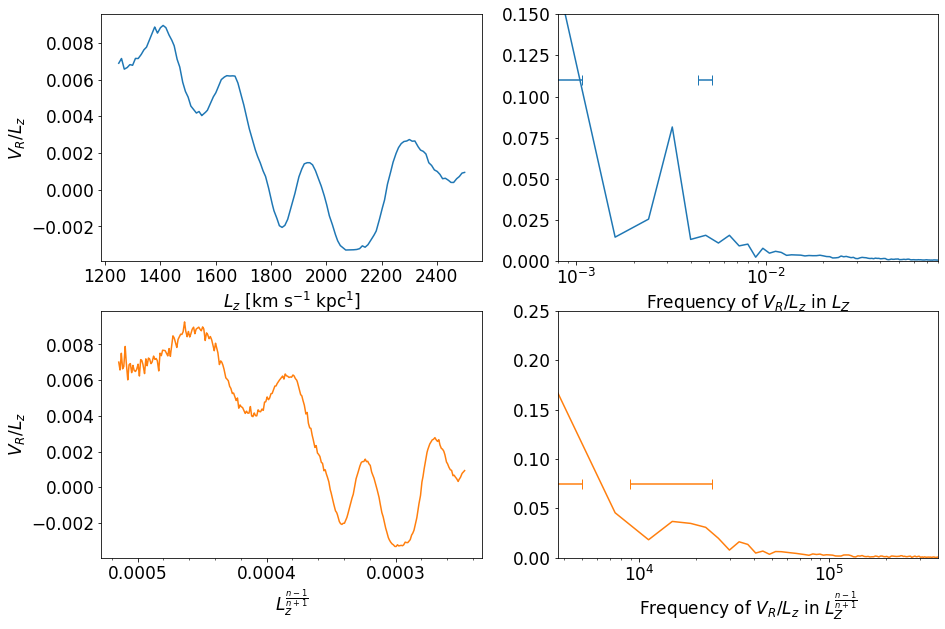

In [24]:
# Plot the untransformed and transformed (with Lz**((n+1)/(n-1))) Gaia data
# and the corresponding Fourier transfors

plt.rcParams['font.size'] = 17

XMIN=1250
XMAX=2500
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2, new=True)
DATA = True

fig, ax = plt.subplots(2,2,figsize=(15,10))

# Untransformed plot
nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, BINSIZE)
N = 100000
xpol, ypol = curve_from_bins(nx, ny, N)
xfr, yf = fourier_from_curve(xpol, ypol)

cplt = ax[0][0]
cplt.plot(xpol, ypol, c='C0')
cplt.set_aspect('auto')
cplt.set_xlabel(r'$L_z$ [km s$^{-1}$ kpc$^{1}$]')
cplt.set_ylabel(r'$V_R/L_z$')

cplt = ax[0][1]
cplt.plot(1/xfr, np.abs(yf)/np.sum(np.abs(yf)), color='C0')
cplt.set_xlim(1/max(xfr), 1/xfr[100])
cplt.set_xscale('log')
cplt.set_aspect('auto')
cplt.set_xlabel('Frequency of $V_R/L_z$ in $L_Z$')
cplt.set_ylim(0,0.15)

avgs = (xfr[1:] + xfr[:-1])/2
cplt.errorbar(x=0, y=0.11, xerr=[[0], [1/avgs[0]]], color='C0', capsize=5)
cplt.errorbar(x=1/xfr[5], y=0.11, xerr=[[abs(1/xfr[5]-1/avgs[4])], [abs(1/xfr[5]-1/avgs[5])]], color='C0', capsize=5)


# Transformed plot
n = -0.03
Lzl = Lz**((n-1)/(n+1))
nx, ny = smooth_bins(Lzl, VR/Lz, np.min(Lzl), np.max(Lzl), 1e-6)
N = 100000
xpol, ypol = curve_from_bins(nx, ny, N)
xfr, yf = fourier_from_curve(xpol, ypol)

axb = ax[1][0]
axb.plot(xpol, ypol, c='C1')
axb.set_xlabel(r'$L_z^\frac{n-1}{n+1}$')
axb.set_ylabel(r'$V_R/L_z$')
#axb.spines['top'].set_color('C1')
#axb.tick_params(axis='x', colors='C1')
#axb.xaxis.label.set_color('C1')
axb.set_xlim(axb.get_xlim()[::-1])
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
axb.xaxis.set_minor_locator(AutoMinorLocator())
axb.locator_params(axis='x', nbins=4)

axb = ax[1][1]
axb.plot(1/xfr, np.abs(yf)/np.sum(np.abs(yf)), color='C1')
print(1/xfr[np.argmax(np.abs(yf))])
axb.set_xlim(1/max(xfr), 1/xfr[100])
axb.set_ylim(0,0.250)
axb.set_xscale('log')
axb.set_aspect('auto')
axb.set_xlabel(r'Frequency of $V_R/L_z$ in $L_Z^{\frac{n-1}{n+1}}$')

avgs = (xfr[1:] + xfr[:-1])/2
axb.errorbar(x=0, y=0.075, xerr=[[0], [1/avgs[0]]], color='C1', capsize=5)
axb.errorbar(x=1/avgs[3], y=0.075, xerr=[[abs(1/avgs[3]-1/avgs[1])], [abs(1/avgs[3]-1/avgs[5])]], color='C1', capsize=5)

namef='plots/fourier_data2'+'.png'
plt.savefig(namef, bbox_inches='tight')

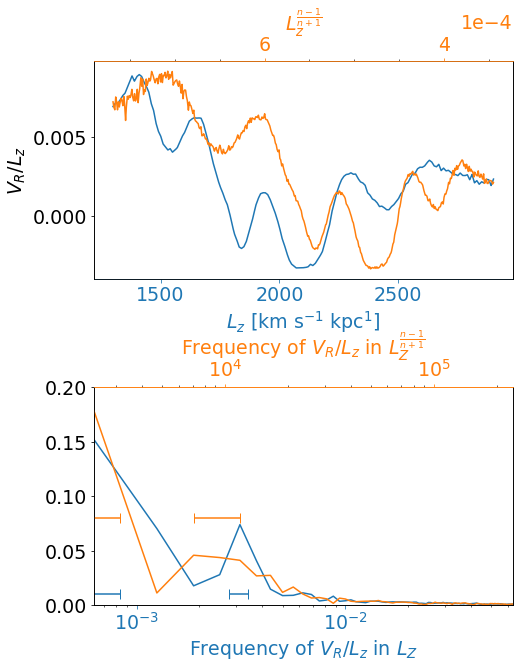

In [36]:
# Plot the untransformed and transformed (with Lz**((n+1)/(n-1))) Gaia data and
# the corresponding Fourier transforms (compact version)

plt.rcParams['font.size'] = 19

XMIN=1300
XMAX=2900
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2, new=True)
DATA = True

fig, ax = plt.subplots(2,1,figsize=(7.5,10))
plt.subplots_adjust(hspace=0.5)

# Untransformed plot
nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, BINSIZE)
N = 100000
xpol, ypol = curve_from_bins(nx, ny, N)
xfr, yf = fourier_from_curve(xpol, ypol)

ax[0].plot(xpol, ypol, c='C0')
ax[0].set_aspect('auto')
ax[0].spines['bottom'].set_color('C0')
ax[0].tick_params(axis='x', colors='C0')
ax[0].set_xlabel(r'$L_z$ [km s$^{-1}$ kpc$^{1}$]')
ax[0].xaxis.label.set_color('C0')
ax[0].set_ylabel(r'$V_R/L_z$')

ax[1].plot(1/xfr, np.abs(yf)/np.sum(np.abs(yf)), color='C0')
ax[1].set_xlim(1/max(xfr), 1/xfr[100])
ax[1].set_xscale('log')
ax[1].set_aspect('auto')
ax[1].set_xlabel('Frequency of $V_R/L_z$ in $L_Z$')
ax[1].set_ylim(0,0.2)
ax[1].spines['top'].set_color('C1')
ax[1].tick_params(axis='x', colors='C0')
ax[1].xaxis.label.set_color('C0')
avgs = (xfr[1:] + xfr[:-1])/2

ax[1].errorbar(x=0, y=0.01, xerr=[[0], [1/avgs[0]]], color='C0', capsize=5)
ax[1].errorbar(x=1/xfr[4], y=0.01, xerr=[[abs(1/xfr[4]-1/avgs[3])], [abs(1/xfr[4]-1/avgs[4])]], color='C0', capsize=5)


# Transformed plot
n = 0.00  # This is the n for the transformation
Lzl = Lz**((n-1)/(n+1))
nx, ny = smooth_bins(Lzl, VR/Lz, np.min(Lzl), np.max(Lzl), 1e-6)
N = 100000
xpol, ypol = curve_from_bins(nx, ny, N)
xfr, yf = fourier_from_curve(xpol, ypol)

axb = ax[0].twiny()
axb.plot(xpol, ypol, c='C1')
axb.spines['top'].set_color('C1')
axb.tick_params(axis='x', colors='C1')
axb.set_xlabel(r'$L_z^\frac{n-1}{n+1}$')
axb.xaxis.label.set_color('C1')
axb.set_xlim(axb.get_xlim()[::-1])
axb.ticklabel_format(style='sci', scilimits=(-4,4))
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
axb.xaxis.set_minor_locator(AutoMinorLocator())
axb.locator_params(axis='x', nbins=4)

axb = ax[1].twiny()
axb.plot(1/xfr, np.abs(yf)/np.sum(np.abs(yf)), color='C1')
axb.set_xlim(1/max(xfr), 1/xfr[100])
axb.set_ylim(0,0.20)
axb.set_xscale('log')
axb.set_aspect('auto')
axb.set_xlabel(r'Frequency of $V_R/L_z$ in $L_Z^{\frac{n-1}{n+1}}$')
axb.spines['top'].set_color('C1')
axb.tick_params(axis='x', colors='C1')
axb.xaxis.label.set_color('C1')

avgs = (xfr[1:] + xfr[:-1])/2

axb.errorbar(x=0, y=0.08, xerr=[[0], [1/avgs[0]]], color='C1', capsize=5)
axb.errorbar(x=1/xfr[3], y=0.08, xerr=[[abs(1/xfr[3]-1/xfr[2])], [abs(1/xfr[3]-1/xfr[4])]], color='C1', capsize=5)


namef='plots/fourier_data'+'.png'
plt.savefig(namef, bbox_inches='tight')